# Notes:

* this Notebook is now modified to match to a smaller maze results
* maze radius is set to be bigger then the far targets in order to reduce collisions
* results are written to MultipleTargets tb log dir in order to keep all logs at the same place

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys


from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.utils import set_random_seed

import matplotlib.pyplot as plt

sys.path.append('..')

import MazeEnv.MultiTargetMazeEnv as mtmz
from MazeEnv.MazeEnv import Rewards
from Utils import make_circular_map, clear_files, get_multi_targets_circle_envs
from Evaluation import EvalAndSaveCallback, MultiTargetEvalAndSaveCallback
import Evaluation

from IPython.display import Image
import ipyplot
import glob

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


pybullet build time: May 25 2021 20:16:47


In [3]:

targets = np.genfromtxt("TestTargets/test_coords.csv", delimiter=',')
REWARDS = Rewards(target_arrival=1, collision=-1, timeout=0, fall=-1, idle=-0.2e-3)


_, eval_env = get_multi_targets_circle_envs(radius=4,
                                            targets=targets,
                                            timeout_steps=200,
                                            rewards=REWARDS,
                                            monitor_dir="logs/FineTuneMultiple/tmp",
                                            xy_in_obs=False)
                              

# Visual Results
load trained model and show visual results on subset of the targets:

In [5]:
trained_model_dir = os.path.join("logs/MultiTargets/TargetEpsilon0.5_16m_largerBoundries/")

new_results_dir = os.path.join("logs", "FineTuneMultiple")

model = DDPG.load(os.path.join(new_results_dir, "best_model"))

In [5]:
# clear_files('logs/FineTuneMultiple/OldFinal/*')

# Per Target Success Rate (During Training)

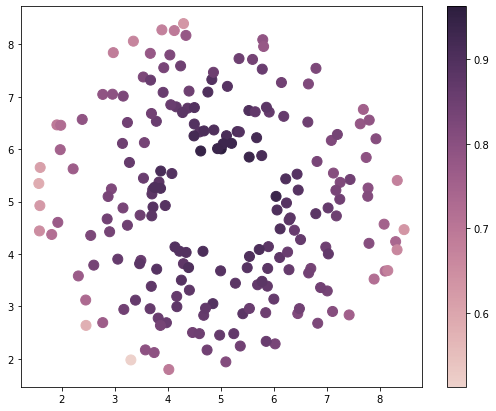

In [6]:
# print(targets)
target_success_rates = np.genfromtxt(os.path.join(trained_model_dir, "per_target_success_rate.csv"))

cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=[9,7])
points = ax.scatter(x=targets[:,0], y=targets[:,1], c=target_success_rates, s=100, cmap=cmap)
f.colorbar(points)

# Keep training

In [9]:
#creates new folder
RUN_NAME="TargetEpsilon0.5_larger_boundaries_another_5M"
os.makedirs(os.path.join("logs/MultiTargets", RUN_NAME), exist_ok=True)

TOTAL_TIME_STEPS = 10_000_000
LEARNING_RATE = 1e-6
REDUCE_LR = True
EXPLORATION_NOISE_STD = 0.04
BATCH_SIZE=1024

EVAL_FREQ = 100_000
VIDEO_FREQ = 25

# should be similar to pretrained model:
REWARDS = Rewards(target_arrival=1, collision=-1, timeout=0, idle=-0.2e-3, fall=-1)
TIMEOUT_STEPS = 200

In [10]:
maze_env, eval_maze_env = get_multi_targets_circle_envs(radius=4,
                                                        targets = targets,
                                                        timeout_steps=TIMEOUT_STEPS,
                                                        rewards=REWARDS,
                                                        monitor_dir=os.path.join("logs/MultiTargets", RUN_NAME, "results"),
                                                        xy_in_obs=False)
 

# create callback for evaluation
callback = MultiTargetEvalAndSaveCallback(log_dir="logs/FineTuneMultiple",
                                          eval_env=eval_maze_env,
                                          eval_freq=EVAL_FREQ,
                                          eval_video_freq=VIDEO_FREQ,
                                          verbose=1)

def lr_func(progress):
    if progress < 0.33 and REDUCE_LR:
        return LEARNING_RATE/20
    if progress < 0.66 and REDUCE_LR:
        return LEARNING_RATE/10
    return LEARNING_RATE


exploration_noise = NormalActionNoise(mean=np.array([0]*8), sigma=np.array([EXPLORATION_NOISE_STD]*8))

model = DDPG.load(os.path.join(trained_model_dir, "best_model"), 
                  env=maze_env,
                  custom_objects=dict(tensorboard_log="./logs/MultiTargets/tb",
                                      device=device,
                                      learning_rate=lr_func,
                                      batch_size=BATCH_SIZE,
                                      verbose=0,
                                     )
                 )

In [11]:
# clear old videos: 
clear_files('logs/FineTuneMultiple/*.gif')
# clear_files('logs/FineTuneMultiple/*.avi')

In [12]:
start = time.time()

model.learn(total_timesteps=TOTAL_TIME_STEPS, 
            callback=callback,
            tb_log_name=RUN_NAME)

print("time", time.time() - start)

100000.00 Steps evaluation, avg reward:0.84, avg episode length: 93.58, success rate: 0.89
--Saving new best model--
200000.00 Steps evaluation, avg reward:0.78, avg episode length: 87.22, success rate: 0.88
300000.00 Steps evaluation, avg reward:0.88, avg episode length: 67.53, success rate: 0.94
--Saving new best model--
400000.00 Steps evaluation, avg reward:0.90, avg episode length: 68.22, success rate: 0.95
--Saving new best model--
500000.00 Steps evaluation, avg reward:0.96, avg episode length: 61.64, success rate: 0.98
--Saving new best model--
600000.00 Steps evaluation, avg reward:0.91, avg episode length: 62.12, success rate: 0.96
700000.00 Steps evaluation, avg reward:0.93, avg episode length: 65.28, success rate: 0.95
800000.00 Steps evaluation, avg reward:0.96, avg episode length: 62.18, success rate: 0.98
900000.00 Steps evaluation, avg reward:0.91, avg episode length: 60.87, success rate: 0.95
1000000.00 Steps evaluation, avg reward:0.90, avg episode length: 59.70, succ

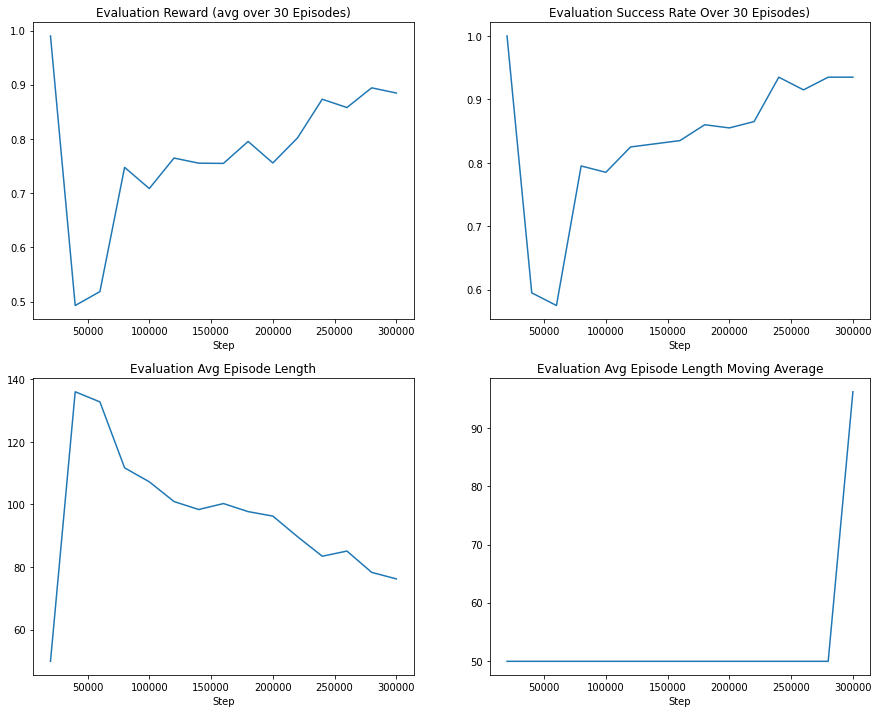

In [39]:
Evaluation.plot_train_eval_results("logs/FineTuneMultiple", 30)